Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

In [ ]:
!pip3 install control --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np, pylab as plt
import control as ct, cv2

import matplotlib.animation as animation

from matplotlib import rc
rc('animation', html='jshtml')

# SPDL class

In [ ]:
class SPDL_DB():
    def __init__(self, n=16, n_step=100, t=10):
        self.n = n
        self.n_step = n_step
        self.t = t
        # init
        self.N = n*n
        self.T = np.linspace(0, t, n_step)
        self.mode = None
        self.sys = None

    def reset(self, mode=None) :
        self.mode = mode if mode != None else np.random.randint(3)
        # one complex system
        if self.mode == 0 :
          self.sys = ct.rss(states=4, outputs=self.N, inputs=self.N)
        # multiple simple system
        else :
          ss = []
          # random system
          if self.mode == 1 :
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.rss(1), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # a/s+1
          else :
            a = 2*np.random.random((self.n,self.n)) - 1
            G = cv2.blur(a,(self.n,self.n))
            g = G.flatten() #g_2D = G.reshape(G.shape)
            for i in range(self.N) :
              subsys = ct.LinearIOSystem(ct.TransferFunction(g[i],[1,1]), name=str(i), inputs='u', outputs='y')
              ss += [subsys]
          # interconnect (disjoint here)
          in_ , out_ = [f'u[{i}]'  for i in range(self.N)], [f'y[{i}]'  for i in range(self.N)]
          inplist, outlist = [[f'{i}.u'] for i in range(self.N)], [[f'{i}.y'] for i in range(self.N)]
          self.sys = ct.InterconnectedSystem(ss, inplist=inplist, inputs=in_, outlist=outlist, outputs=out_)

    def step(self) :
        # initial state
        X0 = 2*np.random.random((self.N,1)) - 1
        # random input for each time
        U = 2*np.random.random((self.N,self.n_step)) - 1 # TO DO --> 3D blur
        # simulate
        if self.mode == 0 :
          T, yout = ct.forced_response(self.sys, T=self.T, U=U, X0=X0[:4])
        else :
          T, yout = ct.input_output_response(self.sys, T=self.T, U=U, X0=X0)
        return U.T, yout.T

    def animate(self, S):
      fig, ax = plt.subplots()
      ims, i = [], 0
      for s in S :
        s_2D = s.reshape((self.n,self.n))
        blur = cv2.blur(s_2D,(3,3))
        im = ax.imshow(s_2D, animated=True)
        if i == 0 : ax.imshow(blur); i+=1
        ims.append([im])
      anim = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=True)
      return anim

# SPDL Database Contruct

In [ ]:
spdl = SPDL_DB()
spdl.reset(0)

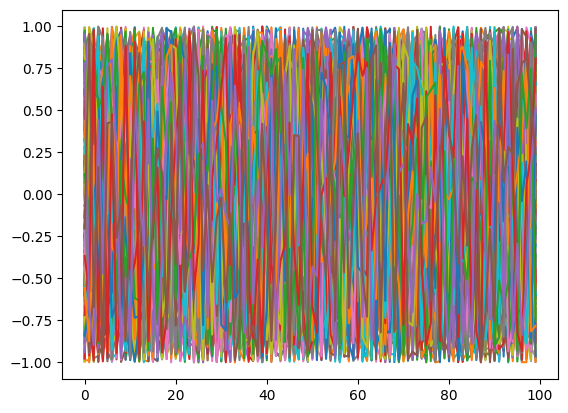

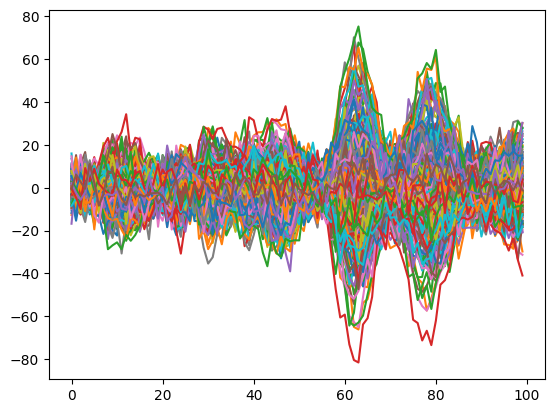

In [ ]:
action, state = spdl.step()
plt.plot(action); plt.show()
plt.plot(state); plt.show()

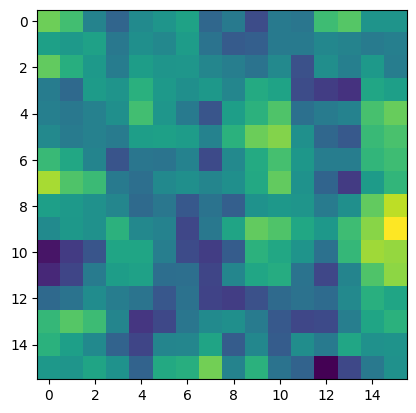

In [ ]:
spdl.animate(state)